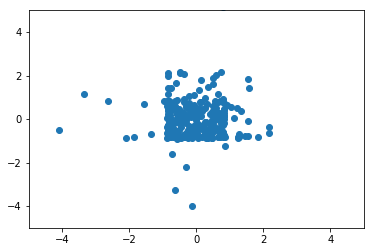

In [224]:
import numpy as np
import matplotlib.pyplot as plt

def generate_tasks(p=0.5, d=100, c=1, n=300, alphas=[], betas=[]):
    '''
    d: dimensionality
    c: scaling factor
    p: correlation
    n: number of data points
    '''
    assert d >= 2, "at least 2 dimension"    
    u1, u2 = np.zeros(d), np.zeros(d)
    u1[0] = 1
    u2[1] = 1
    w1 = c * u1
    w2 = c * (p * u1 + np.sqrt(1-p**2) * u2)
    
    X = []
    Y1 = []
    Y2 = []
    for _ in range(n):
        x = np.random.normal(0, 1, d)
        y1 = w1.dot(x) + np.random.normal(0,0.01)
        y2 = w2.dot(x) + np.random.normal(0,0.01)
        for a, b in zip(alphas, betas):
            y1 += np.sin(a * w1.dot(x) + b)
            y2 += np.sin(a * w2.dot(x) + b)
            
        X.append(x)
        Y1.append(y1)
        Y2.append(y2)
    return np.vstack(X), np.array(Y1), np.array(Y2)

X, Y1, Y2 = generate_tasks(p=0,alphas=[1,2],betas=[3,4])

plt.scatter(Y1, Y2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

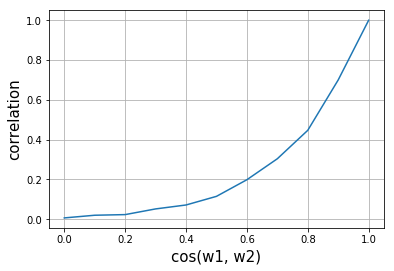

In [204]:
corr = []
pspace = np.linspace(0,1,11)
for p in pspace:
    X, Y1, Y2 = generate_tasks(p=p, n=10000, 
                               alphas=[1,2],
                               betas=[3,4])
    corr.append(np.corrcoef(Y1, Y2)[0,1])
    
plt.plot(pspace, corr)
plt.ylabel('correlation', fontsize=15)
plt.xlabel('cos(w1, w2)', fontsize=15)
plt.grid()
plt.show()

In [174]:
print('number of parameters comparison')
n_neuron = 50
print('shared bottom net:', 100 * 113 + 113 * 8 + 113 * 8 + 8 + 8)
print('deep shared bottom net:', 100 * n_neuron + n_neuron*n_neuron*3 + n_neuron*8*2 + 8*2)
print('deep independent net:', (100 * 32 + 32*32*3 + 32*8 + 8)*2)
print('MMOE:', 100 * 16 * 8 + 16 * 8 * 2 + 8 + 8 + 100 * 8 * 2)

number of parameters comparison
shared bottom net: 13124
deep shared bottom net: 13316
deep independent net: 13072
MMOE: 14672


In [179]:
import torch
import torch.nn as nn

class SharedBottom(nn.Module):

    def __init__(self, l=4):
        '''
        l: number of layers
        '''
        super(SharedBottom, self).__init__()
        self.l = l
        if l == 1:
            a = int(np.round((14672 - 16) / 116))
        else:
            a = int(np.round((-116 + np.sqrt(116**2 + 4*(l-1)*(14672-16))) / (2 * (l-1))))

        print('per layer neuron: {}'.format(a))
        base = [nn.Linear(100, a), nn.ReLU(inplace=True)]
        for _ in range(l-1):
            base.extend([nn.Linear(a, a), nn.ReLU(inplace=True)])
        self.bottom = nn.Sequential(*base)    

        self.top1 = nn.Sequential(
            nn.Linear(a, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)
        )
        self.top2 = nn.Sequential(
            nn.Linear(a, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        shared = self.bottom(x)
        return self.top1(shared), self.top2(shared)
    
    def name(self):
        return 'SharedBottom(l={})'.format(self.l)

class Independent(nn.Module):

    def __init__(self, l=4):
        '''
        l: number of layers
        '''
        super(Independent, self).__init__()
        self.l = l
        if l == 1:
            a = int(np.round((14672/2-8) / 108))
        else:
            a = int(np.round((-108 + np.sqrt(108**2 + 4*(l-1)*(14672/2-8))) / (2 * (l-1))))

        print('per layer neuron: {}'.format(a))
        base1 = [nn.Linear(100, a), nn.ReLU(inplace=True)]
        base2 = [nn.Linear(100, a), nn.ReLU(inplace=True)]
        for _ in range(l-1):
            base1.extend([nn.Linear(a, a), nn.ReLU(inplace=True)])
            base2.extend([nn.Linear(a, a), nn.ReLU(inplace=True)])
        base1.extend([
            nn.Linear(a, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)
        ])
        base2.extend([
            nn.Linear(a, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)            
        ])
        self.top1 = nn.Sequential(*base1)
        self.top2 = nn.Sequential(*base2)

    def name(self):
        return 'Independent(l={})'.format(self.l)
        
    def forward(self, x):
        return self.top1(x), self.top2(x)

class MMOE(nn.Module):

    def __init__(self):
        super(MMOE, self).__init__()

        n_experts = 8
        self.experts = nn.ModuleList()
        for _ in range(n_experts):
            self.experts.append(
                nn.Sequential(
                    nn.Linear(100, 16),
                    nn.ReLU(inplace=True)
                )
            )

        self.gates = nn.ModuleList()
        for _ in range(2): # 2 tasks
            self.gates.append(
                 nn.Sequential(
                    nn.Linear(100, n_experts),
                    nn.Softmax(dim=1)
                )            
            )
        
        
        self.top1 = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)
        )
        self.top2 = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)
        )
        
    def use_gate(self, outputs, gate_outputs):
        '''
        gate_outputs: (n, n_experts)
        '''
        res = 0
        for i in range(len(self.experts)):
            res += gate_outputs[:, i:(i+1)] * outputs[i]
        return res
        
    def forward(self, x):
        outputs = [self.experts[i](x) for i in range(len(self.experts))]
        gate_outputs = [self.gates[i](x) for i in range(2)]
        task1x = self.use_gate(outputs, gate_outputs[0])
        task2x = self.use_gate(outputs, gate_outputs[1])
        return self.top1(task1x), self.top2(task2x)
    
    def name(self):
        return "MMOE"
    
net = SharedBottom(1)
A, B = net(torch.from_numpy(X).float())
A.shape, B.shape

per layer neuron: 126


(torch.Size([300, 1]), torch.Size([300, 1]))

In [180]:
from torch.utils.data import DataLoader  
from torch.utils.data import Dataset

class CosDataset(Dataset):
    
    def __init__(self, p=0.5, d=100, c=1, n=300, alphas=[], betas=[]):
        '''
        d: dimensionality
        c: scaling factor
        p: correlation
        n: number of data points
        '''
        self.X, self.Y1, self.Y2 = generate_tasks(p=p,d=d,c=c,n=n,
                                                  alphas=alphas,betas=betas)
        self.X = torch.from_numpy(self.X).float()
        
    def __len__(self):
        return len(self.Y1)
    
    def __getitem__(self, idx):
        return self.X[idx], (self.Y1[idx], self.Y2[idx])
    
    
def MTL_loss():
    
    def c(yhat, y):
        # regression loss on 2 tasks
        y1, y2 = y
        yhat1, yhat2 = yhat
        c_ = nn.MSELoss()
        return c_(yhat1.view(-1), y1.float().view(-1)) + c_(yhat2.view(-1), y2.float().view(-1))
        
    return c

train_data = DataLoader(CosDataset(p=0.8, n=10000), batch_size=1000)
val_data = DataLoader(CosDataset(p=0.8, n=10000), batch_size=1000)

# complete pipeline

In [217]:
from torch.utils.data import DataLoader
cos_sim = 0
n = 10000
alphas = [1, 2]
betas = [3, 4]
train_data = DataLoader(CosDataset(p=cos_sim, n=n, alphas=alphas, betas=betas), batch_size=min(1000, n))
val_data = DataLoader(CosDataset(p=cos_sim, n=n, alphas=alphas, betas=betas), batch_size=min(1000, n))

In [218]:
from lib.train import TrainFeedForward
nets = [Independent(1), Independent(2), SharedBottom(1), SharedBottom(2), MMOE()]
trainers = []
for net in nets:
    net_name = net.name()
    print(net_name)
    t = TrainFeedForward(net, train_data, val_data=val_data, criterion=MTL_loss(), n_iters=1000,
                         save_filename='models/{}.pth.tar'.format(net_name), n_save=30)
    trainers.append(t)
    t.train()



per layer neuron: 68
per layer neuron: 47
per layer neuron: 126
per layer neuron: 76
Independent(l=1)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation loss
==> validation loss is 1.453
             10|             1%|          0m 0s|        0.01108|        0.00602|        1.45594
             20|             2%|          0m 0s|        0.01262|        0.00766|        1.43411
             30|             3%|          0m 0s|        0.01194|        0.00697|        1.41929
==> evaluating validation loss
==> validation loss is 1.380
             40|             4%|          0m 0s|        0.01176|        0.00679|        1.40661
             50|             5%|          0m 0s|        0.01234|        0.00730|        1.39445
             60|             6%|          0m 0s|        0.01197|        0.00700|        1.38229
==> evaluating validation loss
==> validation loss is 1.351
             70|             7%|          0m 1

            710|            71%|         0m 11s|        0.01300|        0.00772|        0.52594
            720|            72%|         0m 11s|        0.01302|        0.00772|        0.51911
==> evaluating validation loss
==> validation loss is 0.241
            730|            73%|         0m 12s|        0.01302|        0.00773|        0.51246
            740|            74%|         0m 12s|        0.01300|        0.00771|        0.50597
            750|            75%|         0m 12s|        0.01298|        0.00770|        0.49965
==> evaluating validation loss
==> validation loss is 0.229
            760|            76%|         0m 12s|        0.01299|        0.00771|        0.49347
            770|            77%|         0m 12s|        0.01296|        0.00770|        0.48745
            780|            78%|         0m 12s|        0.01298|        0.00772|        0.48156
            790|            79%|         0m 12s|        0.01295|        0.00769|        0.47582
==> evaluating v

            420|            42%|          0m 7s|        0.01360|        0.00726|        0.62032
==> evaluating validation loss
==> validation loss is 0.139
            430|            43%|          0m 7s|        0.01362|        0.00729|        0.60670
            440|            44%|          0m 7s|        0.01358|        0.00726|        0.59366
            450|            45%|          0m 7s|        0.01370|        0.00737|        0.58117
            460|            46%|          0m 7s|        0.01369|        0.00737|        0.56919
==> evaluating validation loss
==> validation loss is 0.131
            470|            47%|          0m 8s|        0.01365|        0.00733|        0.55768
            480|            48%|          0m 8s|        0.01375|        0.00743|        0.54664
            490|            49%|          0m 8s|        0.01380|        0.00746|        0.53602
==> evaluating validation loss
==> validation loss is 0.124
            500|            50%|          0m 8s|    

            120|            12%|          0m 1s|        0.01187|        0.00699|        1.26895
            130|            13%|          0m 1s|        0.01176|        0.00690|        1.24849
==> evaluating validation loss
==> validation loss is 1.088
            140|            14%|          0m 2s|        0.01168|        0.00683|        1.22806
            150|            15%|          0m 2s|        0.01178|        0.00695|        1.20789
            160|            16%|          0m 2s|        0.01170|        0.00688|        1.18804
==> evaluating validation loss
==> validation loss is 1.000
            170|            17%|          0m 2s|        0.01180|        0.00699|        1.16843
            180|            18%|          0m 2s|        0.01174|        0.00693|        1.14894
            190|            19%|          0m 2s|        0.01168|        0.00688|        1.12949
==> evaluating validation loss
==> validation loss is 0.901
            200|            20%|          0m 2s|    

            850|            85%|         0m 12s|        0.01189|        0.00701|        0.36905
==> evaluating validation loss
==> validation loss is 0.182
            860|            86%|         0m 12s|        0.01191|        0.00703|        0.36503
            870|            87%|         0m 13s|        0.01190|        0.00702|        0.36110
            880|            88%|         0m 13s|        0.01192|        0.00705|        0.35726
            890|            89%|         0m 13s|        0.01190|        0.00703|        0.35350
==> evaluating validation loss
==> validation loss is 0.180
            900|            90%|         0m 13s|        0.01189|        0.00702|        0.34982
            910|            91%|         0m 13s|        0.01192|        0.00705|        0.34621
            920|            92%|         0m 13s|        0.01190|        0.00703|        0.34268
==> evaluating validation loss
==> validation loss is 0.177
            930|            93%|         0m 13s|    

            550|            55%|          0m 8s|        0.01243|        0.00719|        0.46527
            560|            56%|          0m 8s|        0.01240|        0.00717|        0.45747
==> evaluating validation loss
==> validation loss is 0.120
            570|            56%|          0m 8s|        0.01238|        0.00715|        0.44992
            580|            57%|          0m 8s|        0.01240|        0.00718|        0.44262
            590|            59%|          0m 9s|        0.01237|        0.00715|        0.43557
==> evaluating validation loss
==> validation loss is 0.110
            600|            60%|          0m 9s|        0.01238|        0.00717|        0.42875
            610|            61%|          0m 9s|        0.01239|        0.00717|        0.42215
            620|            62%|          0m 9s|        0.01241|        0.00719|        0.41579
==> evaluating validation loss
==> validation loss is 0.125
            630|            63%|          0m 9s|    

            260|            26%|          0m 5s|        0.01780|        0.00774|        1.16430
==> evaluating validation loss
==> validation loss is 1.227
            270|            27%|          0m 6s|        0.01780|        0.00777|        1.15008
            280|            28%|          0m 6s|        0.01769|        0.00770|        1.13611
            290|            28%|          0m 6s|        0.01759|        0.00764|        1.12241
==> evaluating validation loss
==> validation loss is 1.230
            300|            30%|          0m 6s|        0.01756|        0.00760|        1.10896
            310|            31%|          0m 6s|        0.01771|        0.00764|        1.09574
            320|            32%|          0m 7s|        0.01766|        0.00762|        1.08277
            330|            33%|          0m 7s|        0.01774|        0.00772|        1.07001
==> evaluating validation loss
==> validation loss is 1.237
            340|            34%|          0m 7s|    

==> validation loss is 1.265
            960|            96%|         0m 20s|        0.01753|        0.00766|        0.66032
            970|            97%|         0m 20s|        0.01750|        0.00764|        0.65777
            980|            98%|         0m 21s|        0.01751|        0.00765|        0.65527
            990|            99%|         0m 21s|        0.01748|        0.00763|        0.65283
==> evaluating validation loss
==> validation loss is 1.265
           1000|           100%|         0m 21s|        0.01745|        0.00762|        0.65043
==> evaluating validation loss
==> validation loss is 1.265


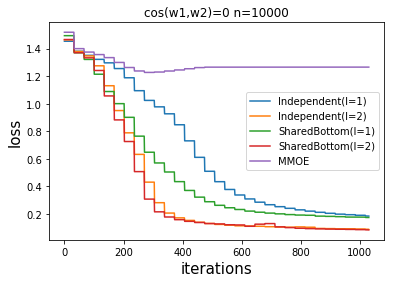

In [219]:
for t in trainers:
    net_name = t.net.name()
    #plt.plot(t.train_losses, label=net_name)
    plt.plot(t.val_losses, label=net_name)
    
plt.legend()
plt.ylabel('loss', fontsize=15)
plt.xlabel('iterations', fontsize=15)
plt.title('cos(w1,w2)={} n={}'.format(cos_sim, n))
plt.savefig('figures/p={},n={}.png'.format(cos_sim,n))
plt.show()
